# Introduction to ML - Decision Tree Coursework COMP70050

## Group Members:  
* Xuhan Zhang
* Judy Zhu
* Shijin Zhang

## Overview
In this assignment, we will implement a decision tree algorithm and use it to determine one of the indoor
locations based on WIFI signal strengths collected from a mobile phone.

In [170]:
import numpy as np
import matplotlib.pyplot as plt

## Step 1: Loading data
load the datasets from the files "wifi_db/clean_dataset.txt" and "wifi_db/noisy_dataset.txt". They contain a 2000x8 array.

In [171]:
def load_datasets():
    # Load the datasets
    clean_data_path = 'wifi_db/clean_dataset.txt'
    noisy_data_path = 'wifi_db/noisy_dataset.txt'

    try:
        clean_dataset = np.loadtxt(clean_data_path)
        noisy_dataset = np.loadtxt(noisy_data_path)

        print("Clean dataset loaded successfully with shape:", clean_dataset.shape)
        print("Noisy dataset loaded successfully with shape:", noisy_dataset.shape)

    except Exception as e:
        print(f"Error loading datasets: {e}")
        return None, None

    return clean_dataset, noisy_dataset

In [172]:
clean_dataset, noisy_dataset = load_datasets()

Clean dataset loaded successfully with shape: (2000, 8)
Noisy dataset loaded successfully with shape: (2000, 8)


## Step 2: Creating Decision Trees
To create the decision tree, it will write a recursive function called `decision tree learning()`, that takes as
arguments a matrix containing the dataset and a depth variable (which is used to compute the maximal depth
of the tree, for plotting purposes for instance). The label of the training dataset is assumed to be the last
column of the matrix.

In [173]:
class DecisionTreeNode:
    def __init__(self, attribute=None, value=None, left=None, right=None, leaf=False, label=None):
        """
        Initialize a decision tree node.

        Args:
            attribute (int): The index of the attribute used for splitting.
            value (float): The value used for splitting the dataset.
            left (DecisionTreeNode): The left child of the node.
            right (DecisionTreeNode): The right child of the node.
            leaf (bool): Whether this node is a leaf node.
            label (int/float): The label of the node if it is a leaf.
        """
        self.attribute = attribute
        self.value = value
        self.left = left
        self.right = right
        self.leaf = leaf
        self.label = label


def find_split(dataset):
    """
    Find the best split point for the dataset
    
    Args:
        dataset (np.ndarray): Dataset with features and labels.
     
    Returns: 
        best_attribute: The best attribute to split on
        best_value: The best value to split the best attribute on
    """
    best_attribute = None
    best_value = None
    best_gain = -1
    n_samples, n_features = dataset.shape

    # Try to find the best split by iterating all unique values over all the attributes 
    for attribute in range(n_features - 1):
        values = np.unique(dataset[:, attribute])
        for value in values:
            left_split = dataset[dataset[:, attribute] <= value]
            right_split = dataset[dataset[:, attribute] > value]
            if len(left_split) > 0 and len(right_split) > 0:
                gain = information_gain(dataset, left_split, right_split)
                if gain > best_gain:
                    best_gain = gain
                    best_attribute = attribute
                    best_value = value

    return best_attribute, best_value


def information_gain(parent, left, right):
    """
    Calculate the information gain of a split
    
    Args:
        parent (np.ndarray): The original dataset before the split.
        left (np.ndarray): The left split dataset.
        right (np.ndarray): The right split dataset.
    
    Returns:
        float: The information gain from the split.
    """
    def entropy(data):
        """
        Calculate the entropy of the given dataset
        """
        labels, counts = np.unique(data[:, -1], return_counts=True)
        probabilities = counts / len(data)
        return -np.sum(probabilities * np.log2(probabilities))

    n = len(parent)
    n_left, n_right = len(left), len(right)
    h_parent = entropy(parent)
    h_left = entropy(left)
    h_right = entropy(right)
    remainder = (n_left / n) * h_left + (n_right / n) * h_right
    return h_parent - remainder


def decision_tree_learning(dataset, depth=0):
    """
    Train a decision tree recursively.

    Args:
        dataset (np.ndarray): The dataset to be used for training.
        depth (int): The current depth of the tree.

    Returns:
        DecisionTreeNode: The root node of the trained decision tree.
    """
    labels = dataset[:, -1]
    # If all labels are the same, return a leaf node
    if len(np.unique(labels)) == 1:
        return DecisionTreeNode(leaf=True, label=labels[0])
    
    best_attribute, best_value = find_split(dataset)
    if best_attribute is None:
        unique, counts = np.unique(labels, return_counts=True)
        majority_label = unique[np.argmax(counts)]
        return DecisionTreeNode(leaf=True, label=majority_label)
    
    # Split the dataset and grow the tree recursively 
    left_split = dataset[dataset[:, best_attribute] <= best_value]
    right_split = dataset[dataset[:, best_attribute] > best_value]
    left_branch = decision_tree_learning(left_split, depth + 1)
    right_branch = decision_tree_learning(right_split, depth + 1)
    
    return DecisionTreeNode(attribute=best_attribute, value=best_value, left=left_branch, right=right_branch)

In [177]:
print("Training decision tree on clean dataset...")
decision_tree = decision_tree_learning(clean_dataset)
print("Decision tree trained successfully.")

Training decision tree on clean dataset...
Decision tree trained successfully.


## Bonus part: Plotting the decision tree
To visualize the decision tree trained on the entire clean dataset.

In [175]:
def plot_tree(node, horizontal_spacing=1.0, vertical_spacing=1.5):
    """
    Draw the structure of the decision tree

    Args:
        node (DecisionTreeNode): The root node of the decision tree.
        horizontal_spacing (float): Scale factor that controls the horizontal distance between nodes.
        vertical_spacing (float): The scaling factor that controls the vertical distance between nodes.
    """
    positions = {}
    connections = []
    x_counter = [0]  # Used to track the current x position

    def compute_positions(node, depth=0):
        if node is None:
            return
        # Calculate the position of the left subtree first
        compute_positions(node.left, depth + 1)
        # Then calculate the position of the right subtree
        compute_positions(node.right, depth + 1)

        # If it is a leaf node, the current x position is directly assigned
        if node.left is None and node.right is None:
            x = x_counter[0]
            positions[node] = (x * horizontal_spacing, -depth * vertical_spacing)
            x_counter[0] += 1  # Add 1 to the x position for the next node
        else:
            # For a non-leaf node, take the average of the left and right child nodes at the x position to ensure that the parent node is centered
            x_values = []
            if node.left:
                x_values.append(positions[node.left][0])
                connections.append((node, node.left))
            if node.right:
                x_values.append(positions[node.right][0])
                connections.append((node, node.right))
            x = sum(x_values) / len(x_values)
            positions[node] = (x, -depth * vertical_spacing)

    compute_positions(node)

    # Gets coordinate values for all nodes
    x_values = [x for x, y in positions.values()]
    y_values = [y for x, y in positions.values()]
    min_x, max_x = min(x_values), max(x_values)
    min_y, max_y = min(y_values), max(y_values)

    # Determine canvas size
    width = max_x - min_x + horizontal_spacing * 2
    height = max_y - min_y + vertical_spacing * 2

    fig, ax = plt.subplots(figsize=(width * 1.2 , height * 1.2))
    ax.axis('off')

    for node in positions:
        x, y = positions[node]
        if node.leaf:
            ax.text(x, y, f"Leaf: {node.label}", ha='center', va='center',
                    bbox=dict(facecolor='lightgrey', edgecolor='black', boxstyle='round,pad=0.2'), fontsize=15)
        else:
            ax.text(x, y, f"[X{node.attribute} <= {node.value}]", ha='center', va='center',
                    bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.2'), fontsize=15)

    # Draw connecting line
    for parent, child in connections:
        x1, y1 = positions[parent]
        x2, y2 = positions[child]
        ax.plot([x1, x2], [y1, y2], color='black', linestyle='-', linewidth=0.8)

    plt.show()


Visualizing the decision tree...


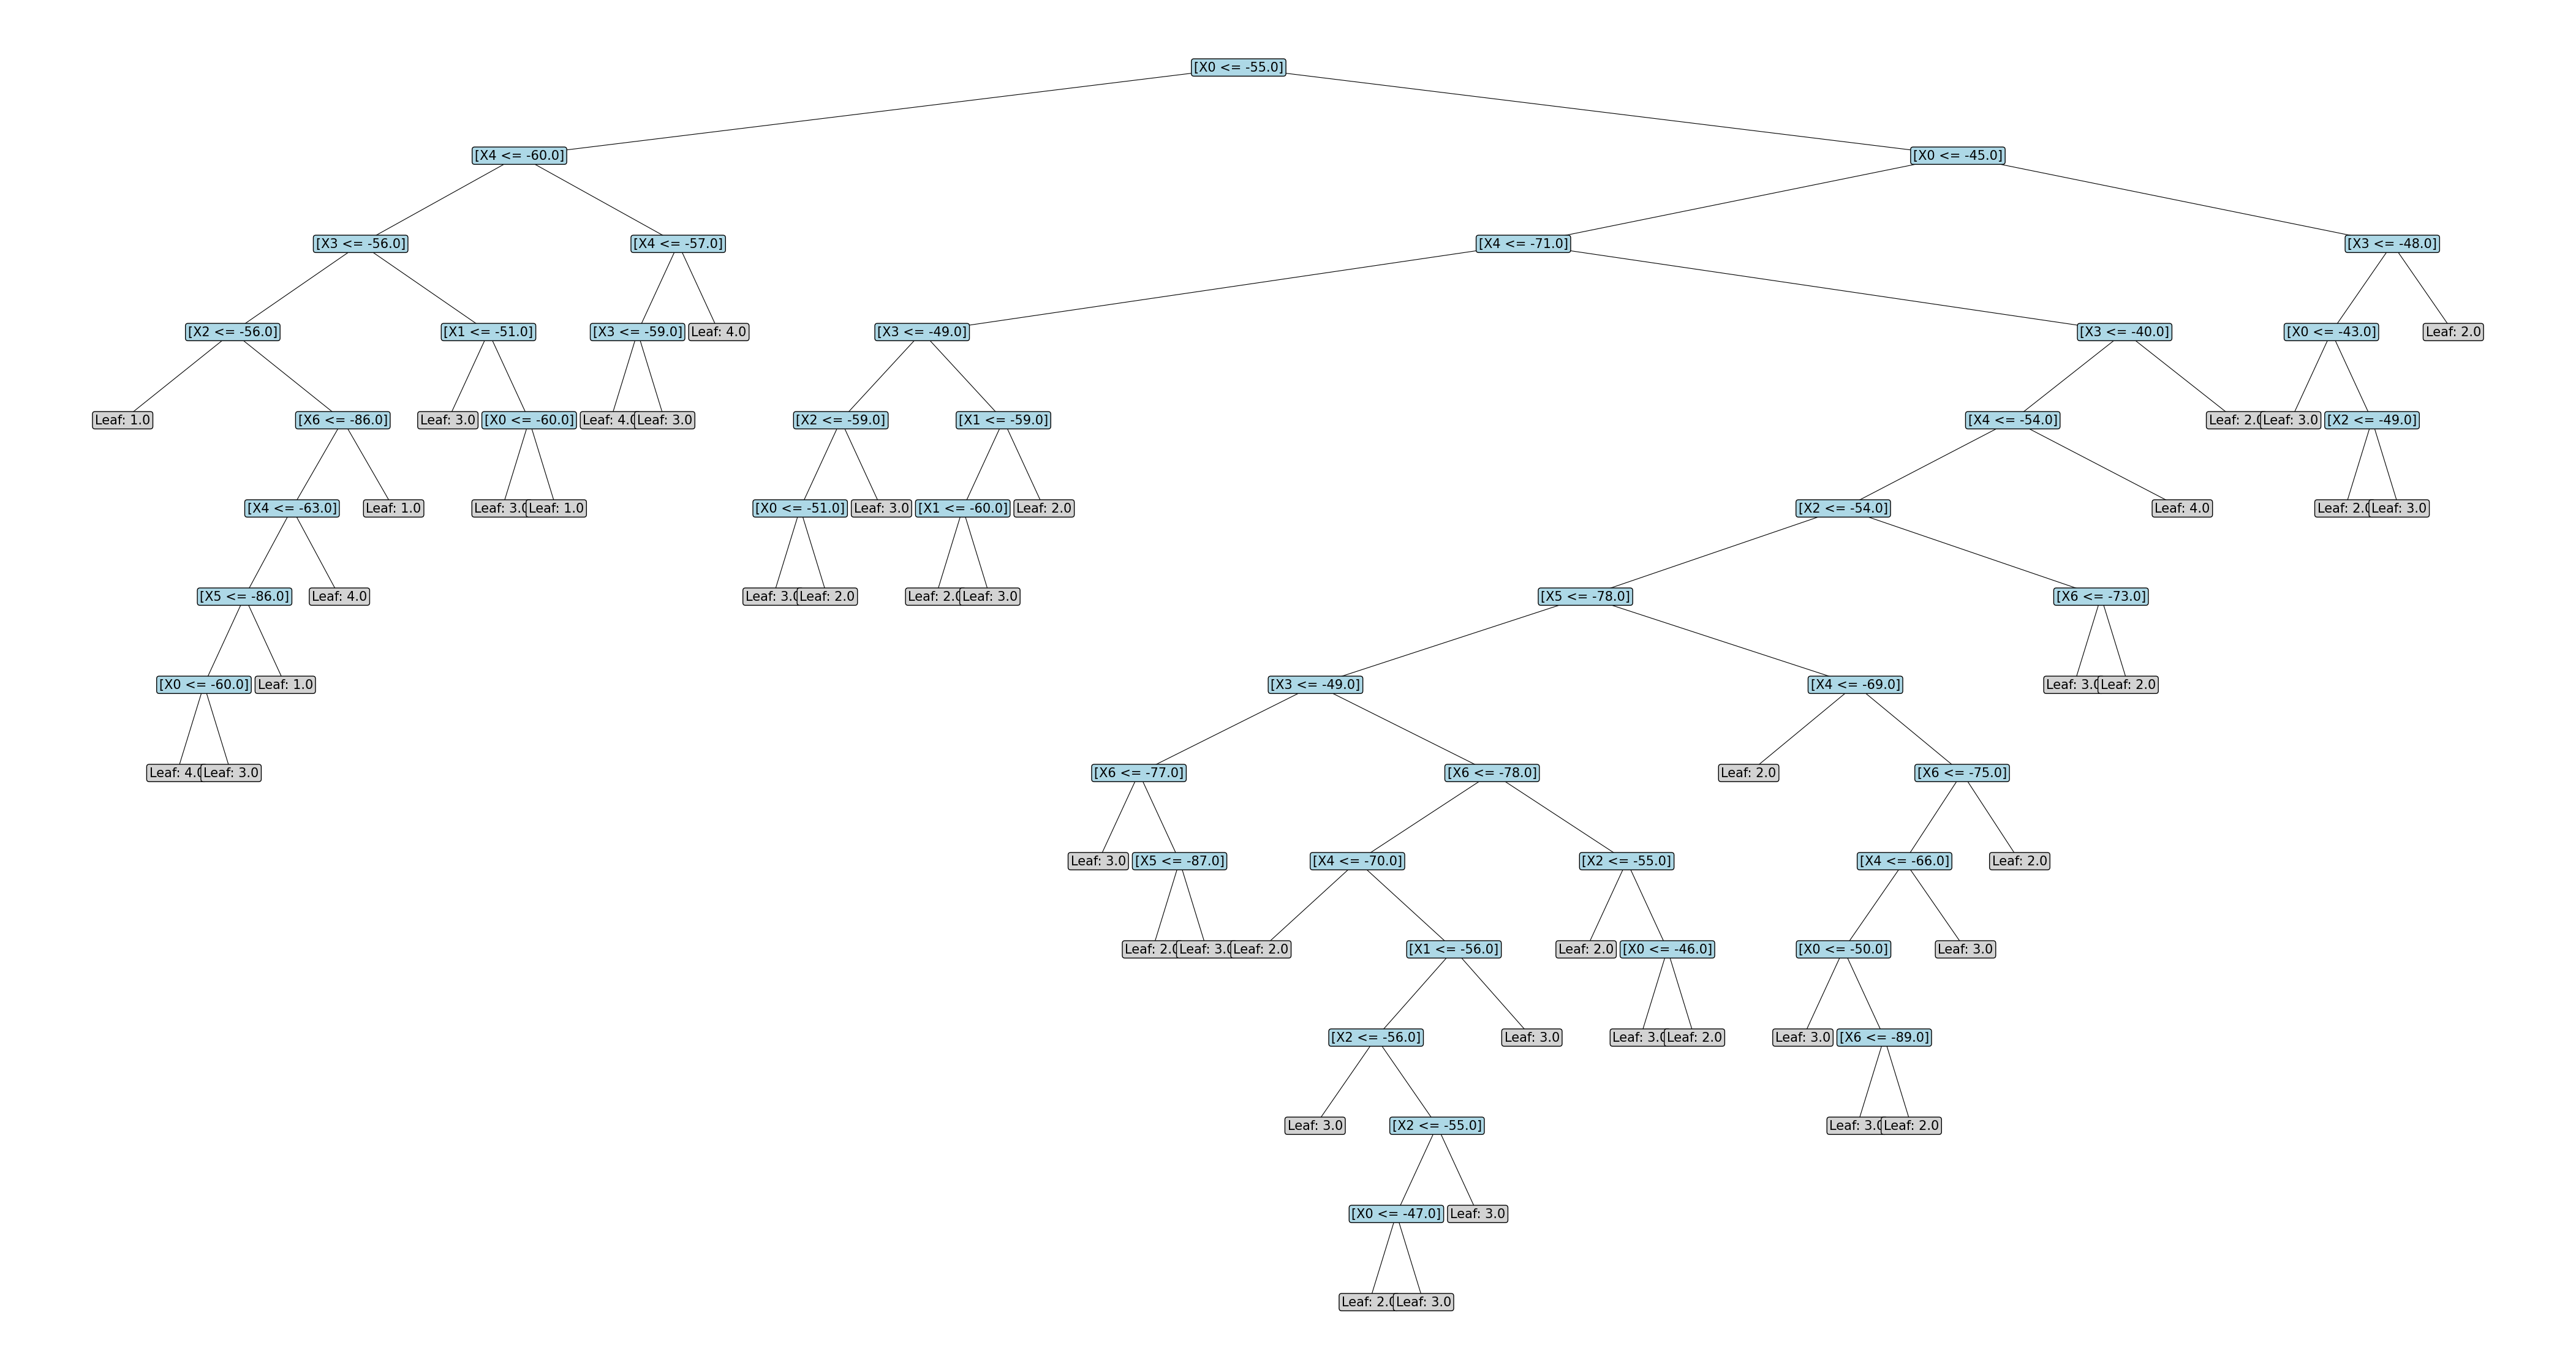

In [176]:
print("Visualizing the decision tree...")
plot_tree(decision_tree)